In [28]:
from __future__ import division

import csv
import json
import sys
import os
import numpy as np
import pandas as pd
import datetime

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

# Experiment parameters
EXP_DATE = '04052017'
MA_TYPE = 'SMA'
COMPONENT = 'Chloride'
# METHOD = 'RS2'
QC_RULES = ['13s','22s']

URefL = 106
LRefL = 99
UTL = 104
LTL =99
WINDOW = 50 


In [29]:
def df_to_series(df, method, qc=False, flags=False):
    
    if qc == False:
        # get the requested test and method and create a new DF
        df_ = df.loc[(df.Test != 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'val'
    elif qc == True:
        df_ = df.loc[(df.Test == 'QC YH CHEM PANEL 1') & (df.Method == method)]
        test = 'qc'


    else:
        print "Set qc flag: true if you want qc, false if you want result values"
        
    if flags == False:
        # take just the data and the value columns
        df_ = df_[['Verified','Value']]
    else:
        df_ = df_[['Verified','Decision']]



    try:
        if len(df_) != 0:
            # save to csv
            df_.to_csv('tmp.csv'.format(test, method), index=False)

            # read csv back in as a series
            series = pd.Series.from_csv('tmp.csv'.format(test, method),header=0)
        else:
            print(test)
            sys.exit("in df_to_series(): df_ was null")
            
    except Exception, e:
        print e 
        
    return series


def simple_moving_average(Window, ValTimeSeries):
    """
    Create a simple moving averages TimeSeries
    In: 
    -> Moving averages window
    -> TimeSeries of values
    Out: TimeSeries of MovingAverages for each of the supplied TimeStamps
    """
    
    ma_rs1_series = ValTimeSeries.copy(deep=True)
    
    for i in range(len(ValTimeSeries)):
        if i == 0:
            continue
        elif i < Window:
            ma_rs1_series[i] = ValTimeSeries[:i].mean()
        else:
            start = i - Window
            ma_rs1_series[i] = ValTimeSeries[start:i].mean()

    return ma_rs1_series


def moving_average_flags(MaTimeSeries, UTL, LTL):
    """
    Create a time series of moving average flags:
    1 = "Out"
    0 = "In"
    
    In: TimeSeries of moving average values
    Out: TimeSeries of 0 or 1 digits representing in and out respectively. 
    """
    
    ma_flag_series = MaTimeSeries.copy(deep=True)
    for i in range(len(MaTimeSeries)):

        if LTL <= MaTimeSeries[i] <= UTL:
            # in = 0
            ma_flag_series[i] = 0
        else: 
            # out = 1
            ma_flag_series[i] = 1
    return ma_flag_series


def moving_avg_performance_metrics(ma_perf_model, moving_avg_flag_series, qc_flag_series):
    """
    Takes flags from Moving Averages and QC and compares to get performance metrics
    
    Input: MA and QC flag timeseries'
    Output: Class object of: TP, FP, TN, FN, Precision, Recall
    """

    rep_perf_data = ReplicatePerformanceModel()
    
    # set replicate parameters
    rep_perf_data.ma_window = WINDOW
    rep_perf_data.ma_utl = UTL
    rep_perf_data.ma_ltl = LTL
    rep_perf_data.ma_url = URefL
    rep_perf_data.ma_lrl = LRefL
    rep_perf_data.ma_window = WINDOW
    
    # set counts to zero
    rep_perf_data.true_positive = 0
    rep_perf_data.false_positive = 0
    rep_perf_data.true_negative = 0
    rep_perf_data.false_negative = 0

    # TODO: Need to seperate logic for high and low MA flags
    # loop through all MA flags and compare to QC flags
    for i in range(len(moving_avg_flag_series)):

        # instantiate the time stamp of i'th MA_flag
        rep_perf_data.ma_flag_ts = moving_avg_flag_series.index[i]
        

        # Check MovingAverage "In" flags relative to QC
        # i.e. True Negatives and False Negatives
        if moving_avg_flag_series[i] == 0:
            
            # instantiate startQcLookup variable with i'th MA_flag
            startQcLookup = moving_avg_flag_series.index[i]
            
            for qc in qc_flag_series[startQcLookup:]:

#                 print (startQcLookup, qc_flag_series.index[0])
                
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]

                if qc == 0:
                    # 'True Negative'
                    rep_perf_data.true_negative+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Negative'
                    rep_perf_data.false_negative+=1

        # Check MovingAverage "Out" flags relative to QC
        # i.e. True Positives and False Positives
        else:
            startQcLookup = moving_avg_flag_series.index[i]
            for qc in qc_flag_series[startQcLookup:]:
                
                # add QC_Flag TimeStamp to MovingAvgPerformanceMetrics
                rep_perf_data.qc_flag_ts = qc_flag_series[startQcLookup:].index[0]
                
                if qc == 1:
                    # 'True Positive'
                    rep_perf_data.true_positive+=1
                else:
                    # ma_flag = 0 & qc_flag = 1
                    # 'False Positive'
                    rep_perf_data.false_positive+=1
                break
    
    # Calculate difference in time between QC flag and MA flag
    rep_perf_data.ma_qc_diff_secs = rep_perf_data.calculate_timestamp_diff()
    rep_perf_data.recall = rep_perf_data.calculate_recall()
    rep_perf_data.precision = rep_perf_data.calculate_precision()
    rep_perf_data.number_of_ma_flags = rep_perf_data.calculate_number_of_flags()
    
    return rep_perf_data

def set_ma_experiment(component, method, ma_type, qc_rules):
    
    ma = MovingAvgExperimentModel()
    
    ma.component = component
    ma.component_method = method
    ma.ma_type = ma_type
    ma.qc_rules = qc_rules

    
    return ma

In [20]:
class MovingAvgExperimentModel:
    
    def __init__(self):

        self.component = str()
        self.component_method = str()
        self.ma_type = str()
        self.qc_rules = list()
        self.replicate_data = []
            
    # dumps Result object in json
    def tojson(self):
        return json.dumps(self, default=lambda o: o.__dict__,
                          sort_keys=False, indent=4)
    
class ReplicatePerformanceModel:

    def __init__(self):

        # Ma/QC Parameters
        self.ma_utl = int()
        self.ma_ltl = int()
        self.ma_url = int()
        self.ma_lrl = int()
        self.ma_window = int()
        self.number_of_ma_flags = int()

        # Performance metrics
        self.true_positive = int()
        self.true_negative = int()
        self.false_positive = int()
        self.false_negative = int()
        self.precision = float()
        self.recall = float()

        # datetime("%Y-%m-%d %H:%M:%S")
        # 2017-01-15 00:15:00
        self.ma_flag_ts = str()
        self.qc_flag_ts = str()
        self.ma_qc_diff_secs = str()

    def calculate_timestamp_diff(self):
        return (self.qc_flag_ts - self.ma_flag_ts).seconds     

    def calculate_recall(self):
        return (self.true_positive / (self.true_positive + self.false_negative))

    def calculate_precision(self):
        if (self.true_positive + self.false_positive) == 0:
            return 0
        else:
            return (self.true_positive / (self.true_positive + self.false_positive))
    
    def calculate_number_of_flags(self):
        return (self.true_positive + self.false_positive)

In [30]:
WORK_DIR = 'C:\\Users\\thoma\\Box Sync\\00Professional\\01Research\\01_Projects\\moving_average\\'
DATA_DIR = WORK_DIR + 'data\\'
OUT_DIR = WORK_DIR + 'out\\'

CSV_PATH = DATA_DIR + 'chloride_rs1_rs2_123016_012917.csv'
EXCEL_PATH = DATA_DIR + 'chloride_rs1_rs2_123016_012917.xlsx'

In [31]:
parse_dates = ['Received', 'Verified']
df = pd.read_csv(CSV_PATH, parse_dates=parse_dates)

In [23]:
## BUG; strip characters from floats. Leaving these causes ints to be objects
#df['Value'] = df['Value'].map(lambda x: x.lstrip('>'))

In [52]:
METHOD = 'RS4'

df = df.sort_values(by='Verified')

# RESULT VALUES #######################################################

# Time series of all result values for a given method
rs1_val_series = df_to_series(df, METHOD, qc=False, flags=False)
norm_rs1_val_series = rs1_val_series[(rs1_val_series <= URefL) & (rs1_val_series >= LRefL)]


# QC VALUES ###########################################################

# time series of all QC values for a given method 
rs1_qc_series = df_to_series(df,METHOD, qc=True, flags=False)

# Time series of low QC values for a given method
low_rs1_qc_series = rs1_qc_series[rs1_qc_series <= 95]

# Time series of high QC values
high_rs1_qc_series = rs1_qc_series[rs1_qc_series >= 95]

# Time series of QC flags for a given method
qc_flags = df_to_series(df,METHOD, qc=True, flags=True)
qc_flags = qc_flags.replace(to_replace='Accept', value=0)
qc_flags = qc_flags.replace(to_replace='Reject', value=1)

print len(rs1_val_series)
print len(norm_rs1_val_series)
print len(rs1_qc_series)
print len(low_rs1_qc_series)
print len(high_rs1_qc_series)
print len(qc_flags)

4285
2713
168
81
87
168


### qc_flags.value_counts()

In [16]:
ExperimentObject = set_ma_experiment(ma_type=MA_TYPE,
                                     component=COMPONENT,
                                     method=METHOD,
                                     qc_rules=QC_RULES)

In [46]:
rs1_val_series.skew()

0.13628034894769728

In [47]:
rs1_val_series.kurtosis()

5.2455939697047853

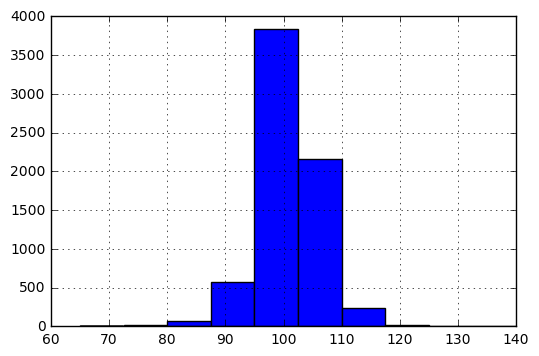

In [48]:
rs1_val_series.hist()

# Replicate experiments here:

In [34]:
norm_rs1_val_series.describe()

count    4216.000000
mean      102.081357
std         2.065769
min        99.000000
25%       100.000000
50%       102.000000
75%       104.000000
max       106.000000
Name: Value, dtype: float64

In [12]:
URefL = 106
LRefL = 99
UTL = 102.9
LTL =99
WINDOW = 50 

In [13]:
ma_rs1_series = simple_moving_average(WINDOW, norm_rs1_val_series)

# Time series of MA flags for a given series, UTL, and LTL
ma_flags = moving_average_flags(ma_rs1_series, UTL, LTL)

ma_flags.value_counts()

0.0    2509
1.0     194
Name: Value, dtype: int64

In [14]:
# compare flags in moving averages with flags in QC
ExperimentObject.replicate_data.append(
                                        moving_avg_performance_metrics(ma_perf_model=ExperimentObject,
                                                                       moving_avg_flag_series=ma_flags,
                                                                       qc_flag_series=qc_flags))

print ExperimentObject.__dict__

{'qc_rules': ['13s', '22s'], 'ma_type': 'SMA', 'component_method': 'RS3', 'component': 'Chloride', 'replicate_data': [<__main__.ReplicatePerformanceModel instance at 0x0000000007A27608>]}


In [15]:
for i in enumerate(ExperimentObject.replicate_data):
    print i[1].__dict__

{'false_positive': 194, 'number_of_ma_flags': 194, 'qc_flag_ts': Timestamp('2017-01-14 22:21:00'), 'ma_url': 106, 'recall': 0.0, 'ma_qc_diff_secs': 22140L, 'ma_utl': 102.9, 'true_negative': 209537, 'precision': 0.0, 'ma_lrl': 99, 'ma_window': 50, 'ma_ltl': 99, 'true_positive': 0, 'ma_flag_ts': Timestamp('2017-01-14 16:12:00'), 'false_negative': 475}


In [16]:
# Convert class object to json
ExperimentObject_json = ExperimentObject.tojson()

# Convert json object to dict
ExperimentObject_dict = json.loads(ExperimentObject_json)

# see contents of replicate_data dictionary
# ExperimentObject_dict['replicate_data']

In [ ]:

keys = ExperimentObject_dict['replicate_data'][0].keys()

with open('output_{}.csv'.format(EXP_DATE), 'wb') as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(ExperimentObject_dict['replicate_data'])

# Visualize Stuff

In [7]:
ma_rs1_series.describe()

NameError: name 'ma_rs1_series' is not defined

In [8]:
URefL = 106
LRefL = 99
UTL = 102.9
LTL =99
WINDOW = 20 

In [9]:
ma_rs1_series = simple_moving_average(WINDOW, norm_rs1_val_series)
# Time series of MA flags for a given series, UTL, and LTL
ma_flags = moving_average_flags(ma_rs1_series, UTL, LTL)
print ma_flags.value_counts()

0.0    2404
1.0     299
Name: Value, dtype: int64


In [17]:
with open('graph_{}.csv'.format(EXP_DATE), 'wb') as output_file:
    w = csv.writer(output_file)
    for i in zip(qc_flags, ma_flags):
         w.writerows(i)

Error: sequence expected

In [18]:
for i in zip(qc_flags, ma_flags):
    print i

(0, 1.0)
(0, 1.0)
(0, 0.0)
(0, 0.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 1.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(1, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(

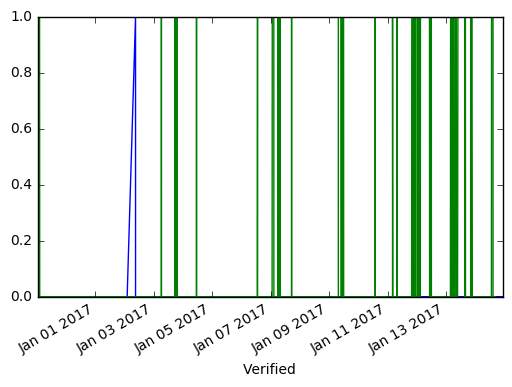

In [10]:
qc_flags.plot()
ma_flags.plot()

In [27]:
len(ma_rs1_series['2017-01-09 00:00:00':'2017-01-13 11:00:00'])

996

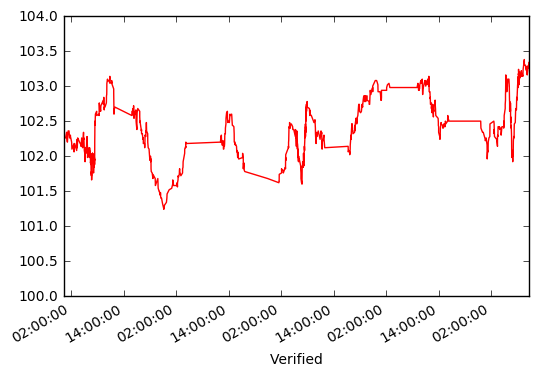

In [30]:
ma_rs1_series['2017-01-09 00:00:00':'2017-01-13 11:00:00'].plot(color='red', ylim=(100,104))


In [63]:
i = 5
window = 5
start = i - window
end = i
norm_rs1_val_series[start:end]

Verified
2016-12-30 00:42:00    103.0
2016-12-30 00:49:00    102.0
2016-12-30 11:20:00    105.0
2016-12-30 11:24:00     99.0
2016-12-30 11:32:00    100.0
Name: Value, dtype: float64

In [66]:
norm_rs1_val_series[:7]

Verified
2016-12-30 00:42:00    103.0
2016-12-30 00:49:00    102.0
2016-12-30 11:20:00    105.0
2016-12-30 11:24:00     99.0
2016-12-30 11:32:00    100.0
2016-12-30 11:32:00    105.0
2016-12-30 11:36:00    100.0
Name: Value, dtype: float64